# Init notebook data
### add our data folder to your Gdrive (its just a sharing you  can remove it afterward)
* go to this link: https://drive.google.com/drive/folders/1rD62zeFpCH7RAuNnvZubaD0oaDVK9ELX
* press on Eran_Eliyahu_cyclgan and then select add shortcut like:

   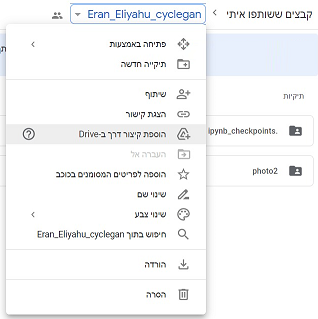
* now select MyDrive and press ADD SHORTCUT like:

   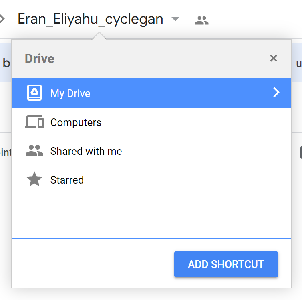
* and you are ready to go

# Preper code for inference

In [9]:
# all needed imports
from pathlib import Path
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision.transforms as transforms
from PIL import Image
from torch import nn
from torch.utils.data import Dataset
from tqdm import tqdm
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [10]:
# check if gpu available 
if torch.cuda.is_available():
    print("Using GPU.")
    device = torch.device('cuda:0')
else:
    print("Using CPU.")
    device = torch.device("cpu")

Using GPU.


In [11]:
# prepare data loader

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

class PhotoDataset(Dataset):
    def __init__(self, photo_folder: Path):
        self.photo_file_paths = list(photo_folder.iterdir())

    def __getitem__(self, index):
        path = self.photo_file_paths[index]
        return transform(Image.open(path).convert('RGB')), path.name

    def __len__(self):
        return len(self.photo_file_paths)


def get_dataloader(photo_folder, batch_size):
    dataset = PhotoDataset(photo_folder)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=False, drop_last=True)

In [12]:
# prepare network architecture

padding_mode = 'reflect'

class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1, stride=1, padding_mode="reflect")
        self.conv2 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1, stride=1, padding_mode="reflect")
        self.relu = nn.ReLU(inplace=True)
        self.norm1 = nn.InstanceNorm2d(channels)
        self.norm2 = nn.InstanceNorm2d(channels)

    def forward(self, x):
        x = self.relu(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        return x


class Cyclegan_Generator(nn.Module):
    def __init__(self, input_nc=3, scale=64, resnet_layers=9):
        super(Cyclegan_Generator, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.norm1 = nn.InstanceNorm2d(scale)
        self.norm2 = nn.InstanceNorm2d(scale * 2)
        self.norm3 = nn.InstanceNorm2d(scale * 4)
        self.norm4 = nn.InstanceNorm2d(scale * 2)
        self.norm5 = nn.InstanceNorm2d(scale)
        self.conv1 = nn.Conv2d(in_channels=input_nc, out_channels=scale, kernel_size=7, padding=3, stride=1, padding_mode="reflect")
        self.down1 = nn.Conv2d(in_channels=scale, out_channels=scale * 2, kernel_size=3, stride=2, padding=1, padding_mode=padding_mode)
        self.down2 = nn.Conv2d(in_channels=scale * 2, out_channels=scale * 4, kernel_size=3, stride=2, padding=1, padding_mode=padding_mode)
        self.up1 = nn.ConvTranspose2d(in_channels=scale * 4, out_channels=scale * 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up2 = nn.ConvTranspose2d(in_channels=scale * 2, out_channels=scale, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.last_conv = nn.Conv2d(in_channels=scale, out_channels=3, kernel_size=7, padding=3, stride=1, padding_mode="reflect")
        self.tanh = nn.Tanh()
        res_layers = []
        self.resnet_layers = resnet_layers
        for i in range(resnet_layers):
            res_layers.append(ResBlock(channels=scale * 4))
        self.res_layers = nn.ModuleList(res_layers)

    def forward(self, x):
        x = self.relu(self.norm1(self.conv1(x)))
        x = self.relu(self.norm2(self.down1(x)))
        x = self.relu(self.norm3(self.down2(x)))
        for i in range(self.resnet_layers):
            x = self.res_layers[i](x) + x
        x = self.relu(self.norm4(self.up1(x)))
        x = self.relu(self.norm5(self.up2(x)))
        x = self.last_conv(x)
        x = self.tanh(x)
        return x

In [13]:
# just tools for showing resutls

def net_results_to_images(torch_image_batch):
    return [(0.5 * (image.detach().permute(1, 2, 0) + 1.0)).cpu() for image in torch_image_batch]


def show_result(photo_image, fake_monet_image):
    fig = plt.figure()
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(photo_image)
    plt.axis("off")
    ax.set_title("Real photo")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(fake_monet_image)
    plt.axis("off")
    ax.set_title("Fake monet")
    # show the images
    plt.show()

In [14]:
  # the code that actually generates the images
  def inference_loop(limited_batch_iteration=None,show_images=10):
      dataloader = get_dataloader(dataset_folder, batch_size)
      for i, (photo_image_batch, file_name_batch) in tqdm(enumerate(dataloader), total=len(dataloader)):
          if limited_batch_iteration is not None and i >= limited_batch_iteration:
            break
          fake_monet_image_batch = generator_photo_to_monet(photo_image_batch.to(device))
          photo_image_list = net_results_to_images(photo_image_batch)
          fake_monet_image_list = net_results_to_images(fake_monet_image_batch)
          for photo_image, fake_monet_image, file_name in zip(photo_image_list, fake_monet_image_list, file_name_batch):
              if show_images>0:
                show_result(photo_image, fake_monet_image)
                show_images=show_images-1
              cv2.imwrite(str(output_images_folder / file_name), fake_monet_image.numpy() * 255)

In [15]:
# finally load everything
photos_folder = "/content/drive/MyDrive/Eran_Eliyahu_cyclegan/photo/"
network_folder = "/content/drive/MyDrive/Eran_Eliyahu_cyclegan/results/monet_transfer/networks"

batch_size = 4

dataset_folder = Path(photos_folder)
networks_folder = Path(network_folder)
output_folder = Path('./Monet_CycleGan/')
output_images_folder = output_folder / 'images'
output_images_folder.mkdir(parents=True, exist_ok=True)

version_name = 'last'  # can be a specific epoch like: 4
generator_photo_to_monet = Cyclegan_Generator().to(device)
generator_photo_to_monet.load_state_dict(torch.load(f"{networks_folder}/{version_name}_generator_b_to_a.pth", map_location=device))

<All keys matched successfully>

# Run inferece (shows the result and zips it)


  0%|          | 0/1759 [00:00<?, ?it/s]

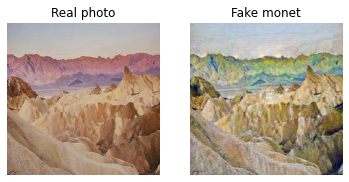

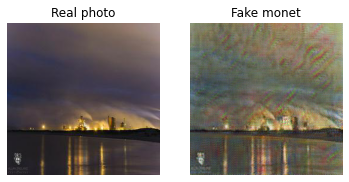

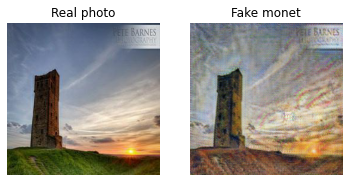

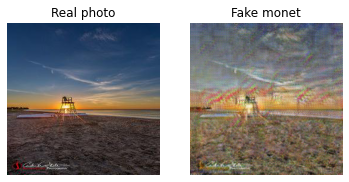


  0%|          | 1/1759 [00:03<1:29:55,  3.07s/it]

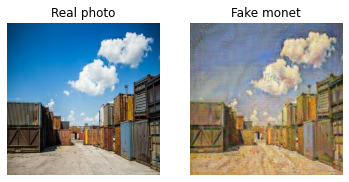

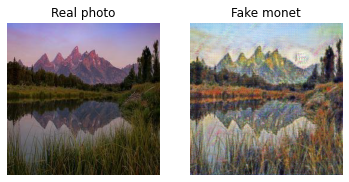

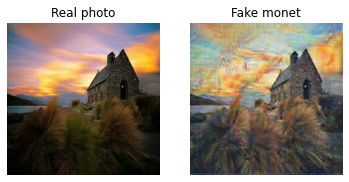

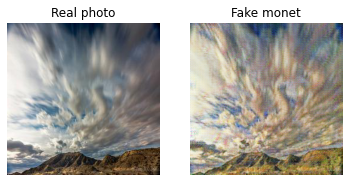


  0%|          | 2/1759 [00:05<1:21:44,  2.79s/it]

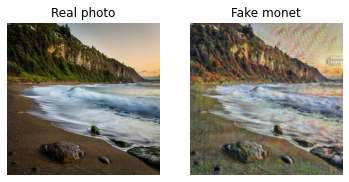

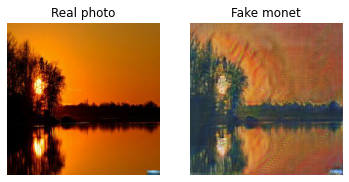


100%|██████████| 1759/1759 [48:03<00:00,  1.64s/it]


'/content/Monet_CycleGan/images.zip'

In [16]:
# to create all the data run without "limited_batch_iteration" argument
inference_loop(limited_batch_iteration=None)

# if you want co clear the folder run: shutil.rmtree(str(output_folder))
shutil.make_archive(output_images_folder, 'zip', str(output_folder))  